# A basic training loop

## MNIST data setup

In [222]:
from pathlib import Path

DATA_PATH = Path('data')
PATH = DATA_PATH/'mnist'

PATH.mkdir(parents=True, exist_ok=True)

In [2]:
import requests

URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

if not (PATH/FILENAME).exists():
    content = requests.get(URL+FILENAME).content
    (PATH/FILENAME).open('wb').write(content)

In [3]:
import pickle, gzip

with gzip.open(PATH/FILENAME, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [4]:
import torch 

x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))

In [5]:
n,c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()

(tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 torch.Size([50000, 784]),
 tensor(0),
 tensor(9))

## Basic model and training loop

In [6]:
import math

weights = torch.randn(784,10)/math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [7]:
import torch.nn.functional as F

def model(xb):
    xb = (xb @ weights) + bias
    return F.log_softmax(xb, dim=-1)

In [8]:
bs=64

In [9]:
preds = model(x_train[0:bs])
preds[0], preds.shape

(tensor([-2.5178, -2.3532, -2.2780, -2.3495, -2.4842, -2.6988, -1.6613,
         -2.5918, -2.5505, -2.0182]), torch.Size([64, 10]))

In [10]:
loss_fn = F.nll_loss
loss_fn(preds, y_train[0:bs])

tensor(2.2830)

In [11]:
lr = 0.5
epochs = 2

In [12]:
from IPython.core.debugger import set_trace

In [13]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
#         set_trace()
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [17]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(0.2273)

## Refactor using nn.Module

In [18]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784,10)/math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        xb = (xb @ self.weights) + self.bias
        return F.log_softmax(xb, dim=-1)

In [19]:
model = Mnist_Logistic()

In [20]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(2.3776)

In [22]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        with torch.no_grad():
            for p in model.parameters(): p -= p.grad * lr
            model.zero_grad()

In [24]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(0.2281)

## Refactor using nn.Linear

In [25]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784,10)

    def forward(self, xb):
        return F.log_softmax(self.lin(xb), dim=-1)

In [26]:
model = Mnist_Logistic()
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(2.2900)

In [27]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        with torch.no_grad():
            for p in model.parameters(): p -= p.grad * lr
            model.zero_grad()

In [29]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(0.2248)

## Refactor using optim

In [30]:
from torch import optim

In [32]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)

loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(2.3373)

In [33]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [35]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(0.2267)

## Refactor using Dataset

In [40]:
from torch.utils.data import TensorDataset

In [41]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=1.)

In [42]:
train_ds = TensorDataset(x_train, y_train)

In [43]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [46]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(0.2155)

## Refactor using DataLoader

In [47]:
from torch.utils.data import DataLoader

In [48]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)

In [49]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [50]:
for epoch in range(epochs):
    for xb,yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [51]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(0.2270)

# Add validation

## First try

In [65]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=1.)

In [66]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

In [67]:
loss_fn(model(x_valid[0:bs]), y_valid[0:bs])

tensor(2.3335)

In [68]:
for epoch in range(epochs):
    model.train()
    for xb,yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_fn(model(xb), yb)
                         for xb,yb in valid_dl)

    print(epoch, valid_loss/len(valid_dl))

0 tensor(0.5329)
1 tensor(0.3838)


## Create fit() and get_data()

In [249]:
def loss_batch(model, xb, yb, opt=None):
    loss = loss_fn(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [250]:
import numpy as np

def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl: loss_batch(model, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[loss_batch(model, xb, yb)
                                for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

        print(epoch, val_loss)

In [251]:
def get_data(train_ds, valid_ds, bs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(valid_ds, batch_size=bs*2))

In [252]:
train_dl,valid_dl = get_data(train_ds, valid_ds, bs)

In [186]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=0.5)

In [187]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.3134230752706528
1 0.3138985332489014


# Switch to CNN

## First try

In [253]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,  16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10,  kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1,1,28,28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        xb = xb.view(-1,xb.size(1))
        return F.log_softmax(xb, dim=-1)

In [254]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr)

In [255]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.7569879179954528
1 0.7223093207120895


## Transformation

In [256]:
from torch.utils.data import Dataset

class TransformedDataset(Dataset):
    def __init__(self, ds, x_tfms=None, y_tfms=None):
        self.ds,self.x_tfms,self.y_tfms = ds,x_tfms,y_tfms
        
    def __len__(self): return len(self.ds)

    def __getitem__(self,i):
        x,y = self.ds[i]
        if self.x_tfms is not None: x = self.x_tfms(x)
        if self.y_tfms is not None: y = self.y_tfms(y)
        return x,y

In [257]:
def mnist2image(v): return v.view(1,28,28)

train_tfm_ds = TransformedDataset(train_ds, mnist2image)
valid_tfm_ds = TransformedDataset(valid_ds, mnist2image)

train_dl,valid_dl = get_data(train_tfm_ds, valid_tfm_ds, bs)

In [258]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,  16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10,  kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        xb = xb.view(-1,xb.size(1))
        return F.log_softmax(xb, dim=-1)

In [259]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr)

In [207]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.6379917875289917
1 0.3226993381023407


## Refactor network

In [260]:
class SimpleCNN(nn.Module):
    def __init__(self, actns, kernel_szs, strides):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(actns[i], actns[i+1], kernel_szs[i], stride=strides[i], padding=kernel_szs[i]//2)
            for i in range(len(strides))])

    def forward(self, xb):
        for conv in self.convs: xb = F.relu(conv(xb))
        xb = F.adaptive_avg_pool2d(xb, 1)
        xb = xb.view(-1,xb.size(1))
        return F.log_softmax(xb, dim=-1)

In [261]:
def get_model():
    model = SimpleCNN([1,16,16,10], [3,3,3], [2,2,2])
    return model, optim.SGD(model.parameters(), lr=lr)

In [262]:
model,opt = get_model()

In [263]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.6613322744369506
1 0.2934833498954773


## CUDA

In [264]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl,self.device = dl,device
        
    def __iter__(self):
        for b in self.dl: yield [o.to(self.device) for o in b]

In [265]:
def get_data(train_ds, valid_ds, bs, device):
    return (DeviceDataLoader(DataLoader(train_ds, batch_size=bs, shuffle=True), device),
            DeviceDataLoader(DataLoader(valid_ds, batch_size=bs*2), device))

In [279]:
default_device = torch.device('cuda')

In [280]:
train_dl,valid_dl = get_data(train_tfm_ds, valid_tfm_ds, bs, default_device)

In [281]:
def get_model():
    model = Simple_CNN([1,16,16,10], [3,3,3], [2,2,2]).to(default_device)
    return model, optim.SGD(model.parameters(), lr=lr)

In [282]:
model,opt = get_model()

In [283]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.4209033682823181
1 0.3435344810962677


# Learner

## Our approach so far

In [287]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))

In [288]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

In [289]:
def mnist2image(v): return v.view(1,28,28)

train_tfm_ds = TransformedDataset(train_ds, mnist2image)
valid_tfm_ds = TransformedDataset(valid_ds, mnist2image)

train_dl,valid_dl = get_data(train_tfm_ds, valid_tfm_ds, bs, default_device)

In [290]:
def get_model():
    model = Simple_CNN([1,16,16,10], [3,3,3], [2,2,2]).to(default_device)
    return model, optim.SGD(model.parameters(), lr=lr)

In [291]:
model,opt = get_model()

In [292]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 2.114867682647705
1 0.9426084690093994


## Refactor to Learner and ModelData

In [300]:
def get_dataloader(x, y, x_tfms, y_tfms, bs, shuffle, device):
        ds = TensorDataset(x, y)
        tfm_ds = TransformedDataset(ds, x_tfms, y_tfms)
        return DeviceDataLoader(DataLoader(tfm_ds, batch_size=bs, shuffle=True), device)

In [318]:
class DataBunch():
    def __init__(self, x_train,y_train,x_valid,y_valid, device=None, x_tfms=None, y_tfms=None):
        self.device = default_device if device is None else device
        self.train_dl = get_dataloader(x_train, y_train, x_tfms, y_tfms, bs,   shuffle=True,  device=self.device)
        self.valid_dl = get_dataloader(x_valid, y_valid, x_tfms, y_tfms, bs*2, shuffle=False, device=self.device)

    @classmethod
    def from_arrays(cls, x_train,y_train,x_valid,y_valid, device=None, x_tfms=None, y_tfms=None):
        x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
        return cls(x_train,y_train,x_valid,y_valid, device, x_tfms, y_tfms)

In [321]:
class Learner():
    def __init__(self, data, model):
        self.data,self.model = data,model.to(data.device)

    def fit(self, epochs, lr, opt_fn=optim.SGD):
        opt = opt_fn(self.model.parameters(), lr=lr)
        loss_fn = F.nll_loss
        fit(epochs, self.model, loss_fn, opt, data.train_dl, data.valid_dl)

In [319]:
data = DataBunch.from_arrays(x_train,y_train,x_valid,y_valid, x_tfms=mnist2image)
model = Simple_CNN([1,16,16,10], [3,3,3], [2,2,2])
learner = Learner(data, model)

In [323]:
learner.fit(epochs, lr)

0 0.3821856246948242
1 0.2894963705539703


# Extending the training loop

## Annealing

In [284]:
import functools

def annealing_no(start, end, pct): return start
def annealing_linear(start, end, pct): return start + pct * (end-start)
def annealing_exp(start, end, pct): return start * ((end/start) ** pct)
def annealing_cos(start, end, pct):
    cos_out = np.cos(np.pi * pct) + 1
    return end + (start-end)/2 * cos_out
    
def do_annealing_poly(start, end, pct, degree): return end + (start-end) * (1-pct)**degree
def annealing_poly(degree): return functools.partial(do_annealing_poly, degree=degree)

In [285]:
annealings = "NO LINEAR COS EXP POLY".split()

In [286]:
a = np.arange(0, 100)
p = np.linspace(0.01,1,100)

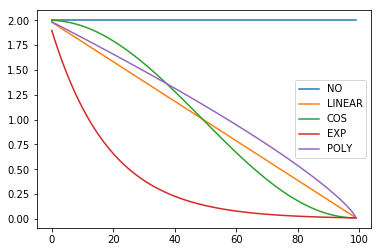

In [233]:
import matplotlib.pyplot as plt

fns = [annealing_no, annealing_linear, annealing_cos, annealing_exp, annealing_poly(0.8)]
for fn, t in zip(fns, annealings):
    plt.plot(a, [fn(2, 1e-2, o) for o in p], label=t)
plt.legend();

## Hyperparam scheduler

In [135]:
def set_val_in_group(val, group, key):
    if key == 'momentum' and 'betas' in group:  group['betas'] = (val, group['betas'][1])
    elif key == 'beta' and 'betas' in group:    group['betas'] = (group['betas'][0], val)
    elif key == 'beta' and 'alpha' in group:    group['alpha'] = val
    else:                                       group[key] = val

In [136]:
class HyperParamScheduler():
    def __init__(self, opt, hyper_param, n_iter, annealing, start, end=None, extra=None):
        self.opt,self.hyper_param,self.n_iter,self.annealing = opt,hyper_param,n_iter,annealing
        self.start,self.end,self.extra = start,end,extra
        # TODO: what's this?
        #if None, default end is 0 (only useful for cosine annealing, so we can decide to remove this)
        if self.end is None and not (self.annealing in [annealing_no, annealing_exp]):
            self.end = 0
        self.reset()
    
    def reset(self):
        self.n = 0
        self.vals = []
        self.set_val(self.start)
        
    def step(self):
        self.n += 1
        # TODO: what's this?
        #This is the class telling anyone listening it's finished: useful for when you want to go the next phase.
        if self.n == self.n_iter: return True
        lr = self.annealing(self.start, self.end, self.n/(self.n_iter-1))
        self.set_val(lr)
        return False
    
    def set_val(self, val):
        if not is_iter(val): val = [val]
        if len(val) == 1: val = val * len(param_group)
        self.vals.append(val[-1])
        for v, g in zip(val,param_group): set_val_in_group(v, g, self.hyper_param)

In [137]:
model = get_model()
opt = optim.SGD(model.parameters(), lr=0.1)

NameError: name 'get_model' is not defined

## lr_find

In [134]:
import collections

In [ ]:
MODEL_PATH = PATH/'models'
MODEL_PATH.mkdir(exist_ok=True)

TEMP_MODEL_NAME = 'tmp.pt'

In [465]:
def save_model(model, fname): torch.save(model.state_dict(), fname)
def load_model(model, fname): model.load_state_dict(torch.load(fname))

In [469]:
def lr_find(model, loss_fn, opt_fn, train_dl, n_iter=200, start_lr=1e-5, end_lr=10):
    opt = opt_fn(model.parameters(), lr=start_lr)
    
    save_model(model, MDL_PATH/'tmp.pt')
    model.train()
    lrs, losses= [], []
    msa_loss, beta = 0, 0.98
    min_loss = 0
    lr_sched = Scheduler(opt, 'lr', n_iter, VarType.EXPONENTIAL, start_lr, end_lr)
    finished = False
    while not finished:
        for xb,yb in train_dl: 
            #pdb.set_trace()
            raw_loss,_ = loss_batch(model, xb, yb, loss_fn, opt)
            # smoothes the loss with a mean average
            msa_loss = beta * msa_loss + (1-beta) * raw_loss
            losses.append(msa_loss / (1 - beta ** (len(losses)+1)))
            finished = lr_sched.step()
            if len(losses) == 1 or msa_loss < min_loss: min_loss = msa_loss
            if finished or msa_loss > 4 * min_loss: break

    load_model(model, MDL_PATH/'tmp.pt')
    return lr_sched.vals, losses

In [149]:
def plot_lr(lrs, losses, skip_start=10, skip_end=5):
    fig, ax = plt.subplots(1)
    lrs = lrs[skip_start:-skip_end] if skip_end !=0 else lrs[skip_start:]
    losses = losses[skip_start:-skip_end] if skip_end !=0 else losses[skip_start:]
    ax.plot(lrs, losses)
    ax.set_xscale('log')

In [470]:
model = get_model()

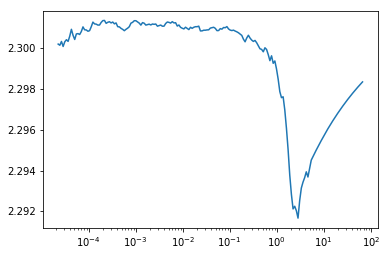

In [471]:
lrs, losses = lr_find(model, loss_fn, optim.SGD, data.train_dl, end_lr=100)
plot_lr(lrs, losses)

## Refactors inside to use the fit function

In [389]:
class Callback():
    def on_train_begin(self): pass
    def on_train_end(self): pass
    def on_batch_begin(self, raw_loss): pass
    def on_batch_end(self, raw_loss): pass

In [390]:
class LossRecorder(Callback):
    beta = 0.98
    
    def on_train_begin(self):
        self.msa_loss,self.losses = 0,[]
        
    def on_batch_end(self, raw_loss):
        self.msa_loss = self.beta * self.msa_loss + (1-self.beta) * raw_loss
        self.losses.append(self.msa_loss / (1 - self.beta ** (len(self.losses)+1)))
        stop = False
        return stop

In [391]:
class LRFinderCallback(LossRecorder):
    def __init__(self, opt, n_iter, start_lr, end_lr):
        self.sched = Scheduler(opt, 'lr', n_iter, VarType.EXPONENTIAL, start_lr, end_lr)
        super().__init__()
        
    def on_train_begin(self):
        self.min_loss = 0
        super().on_train_begin()
    
    def on_batch_end(self, raw_loss):
        super().on_batch_end(raw_loss)
        loss = self.losses[-1]
        if len(self.losses) == 1 or loss < self.min_loss: self.min_loss = loss
        stop = self.sched.step()
        if loss > 4 * self.min_loss: return True
        return stop

In [393]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl=None, callbacks=[]):
    for cb in callbacks: cb.on_train_begin()
    
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            for cb in callbacks: cb.on_batch_begin()
            raw_loss,_ = loss_batch(model, xb, yb, loss_fn, opt)
            if np.any([cb.on_batch_end(raw_loss) for cb in callbacks]): break  
                
        model.eval()
        if valid_dl is not None:
            with torch.no_grad():
                losses,nums = zip(*[loss_batch(model, xb, yb, loss_fn)
                                for xb,yb in valid_dl])
            val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

            print(epoch, val_loss)
            
    for cb in callbacks: cb.on_train_end()

In [394]:
def lr_find(model, loss_fn, opt_fn, train_dl, n_iter=200, start_lr=1e-5, end_lr=10):
    opt = opt_fn(model.parameters(), lr=start_lr)
    save_model(model, MDL_PATH/'tmp.pt')
    
    cb = LRFinderCallback(opt, n_iter, start_lr, end_lr)
    epochs = int(np.ceil(n_iter/len(train_dl)))
    basic_fit(epochs, model, loss_fn, opt, train_dl, callbacks=[cb])
    
    load_model(model, MDL_PATH/'tmp.pt')
    return cb.sched.vals, cb.losses

In [395]:
model = get_model()

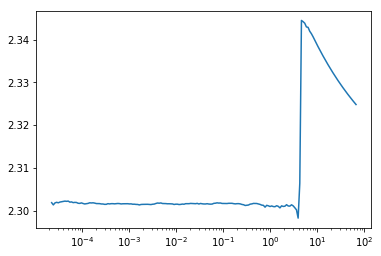

In [396]:
lrs, losses = lr_find(model, loss_fn, optim.SGD, data.train_dl, end_lr=100)
plot_lr(lrs, losses)

## Training phases and SGDR

A few helper functions. The second one is there to map the names of the hyper-parameters in pytorch optimizers to 'momentum' and 'beta' (whether it's SGD, Adam, RMSProp)

In [422]:
def is_tuple(x): return isinstance(x, tuple)

In [456]:
def set_val_in_group(val, group, key):
    if key == 'momentum' and 'betas' in group:  group['betas'] = (val, group['betas'][1])
    elif key == 'beta' and 'betas' in group:    group['betas'] = (group['betas'][0], val)
    elif key == 'beta' and 'alpha' in group:    group['alpha'] = val
    else:                                       group[key] = val

In [457]:
def set_val_in_groups(val, groups, key):
    for g in groups: set_val_in_group(val, g, key)

To simplify the use of training phase, the args lr and mom can either be:
- a single value, then it's assumed to have it constant during the phase
- a tuple (lr1, lr2), then the default is to go linearly from one to the other
- a tuple (lr1, lr2, VarType), then we go from one to the other using the VarType given.

In [458]:
class TrainingPhase():
    
    def __init__(self, epochs, opt_fn, lr, mom=0.9, beta=None, wds=None):
        self.epochs,self.opt_fn,self.beta,self.wds = epochs,opt_fn,beta,wds
        self.start_lr, self.end_lr, self.lr_vType, self.extra_lr = self.decode(lr)
        self.start_mom, self.end_mom, self.mom_vType, self.extra_mom = self.decode(mom)
        
    def decode(self, vals):
        if is_tuple(vals):
            if len(vals) == 2: return vals + (VarType.LINEAR, None)
            elif len(vals) == 3: return vals + (None,)
            else: return vals
        else: return vals, None, VarType.NO, None
    
    def get_scheds(self, opt, n_batch):
        if self.beta is not None: set_val_in_groups(self.beta, opt.param_groups, 'beta')
        if self.wds is not None: set_val_in_groups(self.wds, opt.param_groups, 'weight_decay')
        return [Scheduler(opt, 'lr', n_batch * self.epochs, self.lr_vType, self.start_lr, self.end_lr, self.extra_lr),
               Scheduler(opt, 'momentum', n_batch * self.epochs, self.mom_vType, self.start_mom, self.end_mom, self.extra_mom)]

The class that handles the phases and make sure we go from one to the next is another Callback.

In [460]:
class PhaseScheduler(LossRecorder):
    
    def __init__(self, model, phases, n_batches):
        self.model, self.phases, self.n_batches = model, phases, n_batches
        super().__init__()
        self.phase = 0
        self.opt = None
        self.init_phase()
    
    def init_phase(self):
        cur_phase = self.phases[self.phase]
        #Updates the optimizer
        #Replacing self.model.parameters() by a function that returns the trainable parameters will handle freezing.
        new_opt = cur_phase.opt_fn(self.model.parameters(), lr=cur_phase.start_lr)
        if self.opt is None or type(self.opt) != type(new_opt): self.opt = new_opt
        #Creates the various schedulers
        self.scheds = cur_phase.get_scheds(self.opt, self.n_batches)
        
    def on_batch_end(self, raw_loss):
        super().on_batch_end(raw_loss)
        finished = False
        for sched in self.scheds: finished = finished or sched.step()
        if finished:
            self.phase += 1
            if self.phase == len(self.phases): return True
            self.init_phase()

fitting with phases is then super easy

In [461]:
def fit_phases(phases, model, loss_fn, train_dl, valid_dl=None, callbacks=[]):
    epochs = int(np.ceil(sum([p.epochs for p in phases])))
    cb = PhaseScheduler(model, phases, len(train_dl))
    basic_fit(epochs, model, loss_fn, cb.opt, train_dl, valid_dl, callbacks=[cb])

An example of what a helper function could be.

In [462]:
def sgdr_phases(lr, opt_fn, n_cycle, cyc_len, cyc_mul, mom=0.9, wds=None):
    phases = [TrainingPhase(0.05, opt_fn, lr/100, mom, wds)]
    for i in range(n_cycle):
        epochs = cyc_len - 0.05 if i==0 else cyc_len * (cyc_mul ** i)
        phases.append(TrainingPhase(epochs, opt_fn, (lr,0,VarType.COSINE), mom, wds))
    return phases

In [463]:
model = get_model()

In [464]:
fit_phases(sgdr_phases(1, optim.SGD, 2, 1, 2, wds=1e-4), model, loss_fn, data.train_dl, data.valid_dl)

0 1.347146787261963
1 0.69737041015625
2 0.5230010066509246
